In [1]:
# Загружаем библиотеки
import pandas as pd # Датафреймы pandas
import matplotlib.pyplot as plt # Графики
from sklearn.model_selection import train_test_split # Разделение выборки на обучающую и тестовую
from sklearn.ensemble import RandomForestRegressor # Модель случайного леса
from sklearn.model_selection import cross_val_score # Кросс-валидация
from sklearn.ensemble import StackingRegressor # Стекинг моделей
from sklearn.linear_model import LinearRegression # Модель линейной регрессии
from sklearn.tree import DecisionTreeRegressor # Модель решающего дерева
from sklearn.neighbors import KNeighborsRegressor # Модель k-ближайших соседей
from sklearn.linear_model import RidgeCV # Кросс-валидация с помощью гребневой регрессии
from sklearn.linear_model import Ridge # Гребневая регрессия

#### Загрузка и обработка данных

In [2]:
# Датасет цен на недвижимость
data = pd.read_csv('train.csv')
# Отбросим признак Id - это порядковый номер, полезной информации не несёт
data = data.drop(['Id'], axis = 1, errors = 'ignore')

In [3]:
# Находим числовые признаки, их тип не является object
numeric_features = list(data.dtypes[data.dtypes != object].index)
# Отбросим пропуски в числовых признаках
data = data.dropna(subset = numeric_features)
# Находим категориальные признаки по типу данных object
categorial_features = list(data.dtypes[data.dtypes == object].index)
# Используем унитарное кодирование, пропуски тоже учитываем
data = pd.get_dummies(data, columns = categorial_features, dummy_na = True)

In [4]:
# Признаки
X = data.drop(columns='SalePrice')
# Целевые значения
y = data['SalePrice']
# Разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)  

#### Модель типа случайный лес

In [5]:
# Создаем модель RandomForest и обучаем её
RF = RandomForestRegressor(random_state = 42)
RF.fit(X_train, y_train)
# Получаем список весов всех признаков
features_weight = pd.Series(RF.feature_importances_)
features_weight.index = pd.Series(X_train.columns)

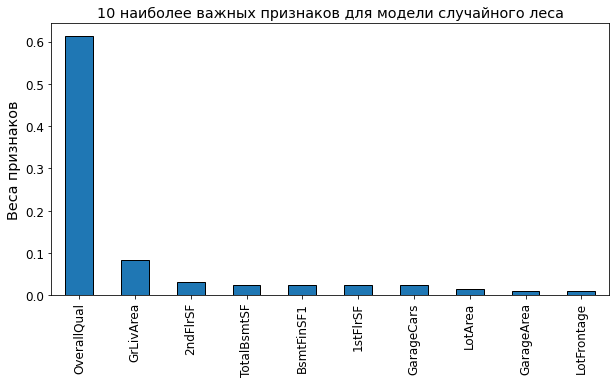

Показатель точности модели случайного леса 0.881


In [6]:
# Строим диаграмму весов 10 наиболее важных признаков
top_10_features = features_weight.sort_values(ascending = False).head(10)
top_10_features.plot(kind = 'bar',
                     figsize = (10, 5),
                     edgecolor = 'black',
                     fontsize = 'large'
                    )
plt.title('10 наиболее важных признаков для модели случайного леса', fontsize = 'x-large')
plt.ylabel('Веса признаков', fontsize = 'x-large') 
plt.show()
print(f'Показатель точности модели случайного леса {round(RF.score(X_test, y_test), 3)}')

#### 10-fold кросс-валидация

In [7]:
# Используем 10-fold кросс-валидацию для модели типа случайный лес 
RF_scores = cross_val_score(RF, X_train, y_train, cv = 10)

In [8]:
print('Показатели точности модели типа случайный лес с использованием 10-fold кросс-валидации:')
print(f'- средний {round(RF_scores.mean(), 3)}')
print(f'- минимальный {round(RF_scores.min(), 3)}')
print(f'- максимальный {round(RF_scores.max(), 3)}')

Показатели точности модели типа случайный лес с использованием 10-fold кросс-валидации:
- средний 0.831
- минимальный 0.702
- максимальный 0.898


#### Стекинг моделей

In [9]:
# Создаем стэкинг моделей и обучаем его, 
# применяем 10-fold кросс-валидацию
Regressor = StackingRegressor([
                               ('Ridge', Ridge(random_state = 42)),
                               ('Linear', LinearRegression()),
                               ('KNeighbors', KNeighborsRegressor()),
                               ('DecisionTree', DecisionTreeRegressor()),   
                               ('RandomForest', RandomForestRegressor(random_state = 42))
                              ], 
                              final_estimator = RidgeCV(),  
                              cv = 10
                             )
Regressor.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('Ridge', Ridge(random_state=42)),
                              ('Linear', LinearRegression()),
                              ('KNeighbors', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor()),
                              ('RandomForest',
                               RandomForestRegressor(random_state=42))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [10]:
# Записываем показатели точности стекинга и отдельных моделей
# Как на обучающих, так и на тестовых данных
score_train = {}
score_test = {}

score_train['Стекинг моделей'] = Regressor.score(X_train, y_train)
score_test['Стекинг моделей'] = Regressor.score(X_test, y_test)

for model in Regressor.named_estimators:
    score_train[model] = Regressor.named_estimators_[model].score(X_train, y_train) 
    score_test[model] = Regressor.named_estimators_[model].score(X_test, y_test) 

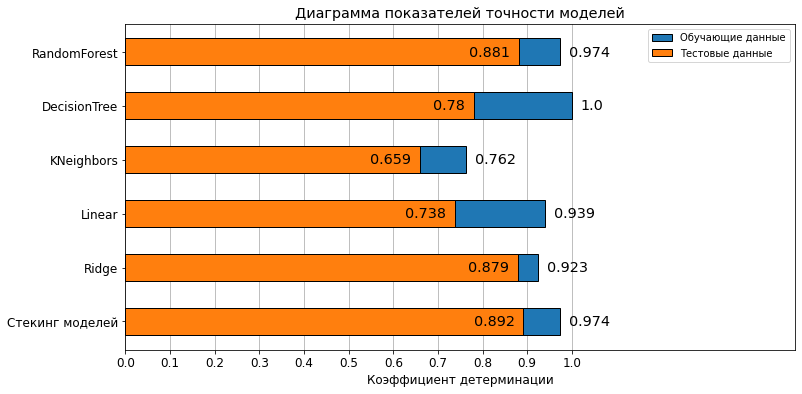

In [11]:
# Строим диаграмму показателей точности
plt.figure(figsize = (12, 6))
plt.barh(list(score_train.keys()),
         list(score_train.values()),
         height = 0.5,
         edgecolor = 'black',
         label = 'Обучающие данные',
         zorder = 2
        )
plt.barh(list(score_test.keys()),
         list(score_test.values()),
         height = 0.5,
         edgecolor = 'black',
         label = 'Тестовые данные',
         zorder = 2
        )

# Выводим показатели точности
for model in list(score_train.keys()):
                  plt.text(score_train[model] + 0.02, 
                  model, 
                  s = round(score_train[model], 3), 
                  fontsize = 'x-large', 
                  verticalalignment = 'center',
                  horizontalalignment = 'left'                    
                 )
for model in list(score_test.keys()):
                  plt.text(score_test[model] - 0.02, 
                  model, 
                  s = round(score_test[model], 3), 
                  fontsize = 'x-large', 
                  verticalalignment = 'center',
                  horizontalalignment = 'right'                    
                 )
        
plt.title('Диаграмма показателей точности моделей', fontsize = 'x-large')
plt.xlabel('Коэффициент детерминации', fontsize = 'large')
plt.tick_params(labelsize = 'large')
plt.xlim((0, 1.5))
plt.xticks([x / 10 for x in range(11)])
plt.legend()
plt.grid(axis = 'x')

plt.show()

#### Выводы:
- одиночная модель типа случайный лес в настоящем примере обеспечивает хорошее качество 0,881
- стекинг 5 моделей позволил поднять показатель качества только лишь на 0,011, достигнут показатель 0,892
- в стекинге наилучшими показателями качества обладают модели случайного леса и гребневой регрессии